# Selekcja Zmiennych

1. [Embedded methods](#Embedded-methods)
    - [Feature Importance w drzewach decyzyjnych](#Feature-Importance-w-drzewach-decyzyjnych)
2. [Filter-based methods](#Filter-based-methods)
    - [Univariate Feature Selection + f-Anova](#Univariate-Feature-Selection-+-f-Anova)
    - [Korelacje](#Korelacje)
3. [Wrapper-based methods](#Wrapper-based-methods)
    - [Recursive Feature Elimination](#Recursive-Feature-Elimination)
    - [Forward Feature Selection](#Forward-Feature-Selection)

## Przygotowanie danych

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

In [3]:
cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [4]:
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
y = cancer['target']
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<b>Atrybuty</b>

- radius - promień (średnia odległości od środka do punktów na obwodzie)
- texture - tekstura (odchylenie standardowe wartości skali szarości)
- perimeter - obwód
- area - powierzchnia
- smoothness - gładkość (lokalna zmienność długości promieni)
- compactness - zwartość (obwód^2 / powierzchnia - 1,0)
- concavity - wklęsłość
- concave points - punkty wklęsłe (liczba wklęsłych części konturu)
- symmetry - symetria
- fractal dimension - wymiar fraktalny ("przybliżenie linii brzegowej" - 1)

# Feature Selection

## Embedded methods

<div class="alert alert-block alert-success">
📍<b>Embedded (intrinsic) methods</b><br>
    Embedded (intrinsic) methods - metody osadzone w modelach, np. drzewa decyzyjne, lasy losowe, Lasso.
</div>

### Feature Importance w drzewach decyzyjnych

<div class="alert alert-block alert-info">
📝 <b>Zadanie 1.1</b><br>
    Przygotujmy model drzewa decyzyjnego z parametrami <code>max_depth=10</code> i <code>min_samples_split=5</code>. <br>
    Następnie, korzystając z atrybutu <code>feature_importances_</code>, wskażmy istotności zmiennych.
</div>

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [6]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
dt.fit(df, y)

DecisionTreeClassifier(max_depth=10, min_samples_split=5)

In [7]:
feature_importances = dict(zip(dt.feature_names_in_, dt.feature_importances_))
feature_importances = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances

worst radius               0.703527
worst concave points       0.115289
worst texture              0.089571
compactness error          0.032205
worst area                 0.011212
mean concave points        0.008871
worst smoothness           0.007472
worst fractal dimension    0.007399
mean smoothness            0.007097
mean texture               0.006518
worst compactness          0.005898
area error                 0.002069
worst concavity            0.001857
smoothness error           0.001015
mean symmetry              0.000000
mean compactness           0.000000
worst symmetry             0.000000
mean perimeter             0.000000
mean area                  0.000000
worst perimeter            0.000000
fractal dimension error    0.000000
mean concavity             0.000000
mean fractal dimension     0.000000
symmetry error             0.000000
concave points error       0.000000
concavity error            0.000000
perimeter error            0.000000
texture error              0

<div class="alert alert-block alert-info">
📝 <b>Zadanie 1.2</b><br>
    Zwizualizujmy istotności zmiennych na wykresie słupkowym.
</div>

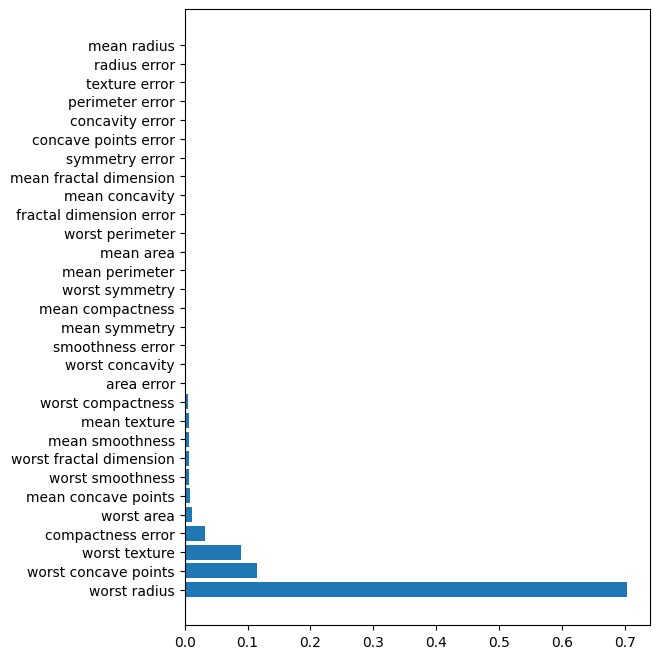

In [8]:
plt.figure(figsize=(6, 8))
plt.barh(feature_importances.index, feature_importances.values)
plt.show()

## Filter-based methods

<div class="alert alert-block alert-success">
📍<b>Filter methods</b><br>
    Filter methods wyróżniają się tym, że mogą być zastosowane przed rozpoczęciem procesu uczenia naszego modelu, przez co stanowią zazwyczaj pierwszy krok w selekcji cech w pipelinach.<br>
Są dobre do eliminacji cech nieistotnych wobec zmiennej objaśnianej, powielanych informacji, wartości zduplikowanych i skorelowanych.
</div>

### Korelacje

Istotne cechy są silnie skorelowane ze <b>zmienną objaśnianą</b>.

<div class="alert alert-block alert-info">
📝 <b>Zadanie 3.1</b><br>
    Sprawdźmy bezwzględne wartości korelacji etykiety ze wszystkimi cechami.<br>
    Przedstawmy te warości na wykresie (np. słupkowym).<br>
    Znajdźmy cechy z największym które najsilniej korelują z etykietą.
</div>

## Wrapper-based methods
<div class="alert alert-block alert-success">
📍<b>Wrapper-based methods - Metody opakowane</b><br>
</div>


### Recursive Feature Elimination

<div class="alert alert-block alert-success">
📍<b>Rekurencyjna Eliminacja Zmiennych - Recursive Feature Elimination</b><br>
    Celem Rekurencyjnej Eliminacji Zmiennych (RFE) jest selekcja rekurencyjnie uwględniająca coraz mniejsze zestawy atrybutów z wykorzystaniem estymatora.<br>

Schemat działania:
<ol>
<li>Obliczenie istotności zmiennej w modelu uwzględniającym pełny zestaw cech.</li>
<li>Usunięcie najmniej istotnych cech.</li>
    W funkcji RFE z scikit-learn, argument <code>step</code> określa liczbę cech, które usuwamy w każdym kroku.
<li>Zbudowanie modelu bez usuniętych cech i obliczenie nowych istotności zmiennych.
<li>Powtarzamy kroki 2.-3., dopóki kryterium stopu nie zostanie osiągnięte.</li>
Kryterium stopu to np. osiągnięcie minimalnej liczby cech w modelu określonej przez użytkownika (W RFE z scikit-learn jest to argument <code>n_features_to_select</code>).
</ol><br>
Zmodyfikowana funkcja RFECV dodatkowo wykorzystuje walidację krzyżową w celu znalezienia optymalnej liczby cech.
</div>


<div class="alert alert-block alert-info">
📝 <b>Zadanie 4</b><br>
    Przygotujmy estymator drzewa decyzyjnego z parametrami <code>max_depth=10</code> i <code>min_samples_split=5</code>.<br>
    Za pomocą rekurencyjnej eliminacji zmiennych, wskażmy 5 istotnych zmiennych (<code>n_features_to_select=5</code>).
    W każdym kroku RFE eliminujmy po jednej zmiennej (<code>step=1</code>).
</div>

In [ ]:
from sklearn.feature_selection import RFE

k_best = 5

<div class="alert alert-block alert-info">
    ❓ <b>Pytanie<br>
    Dlaczego warto eliminować cechy iteracyjnie?</b> <br>
</div>
<br>
